In [7]:
from MMT_reduce_module import *

In [8]:
from __future__ import print_function
import numpy as np
import scipy as sp
import scipy.ndimage
from astropy.io import fits
import sys
import numpy.ma as ma
import math
import pidly
import os
import glob
import time
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()

## MMT_reduce_module Testing

#### The purpose of this notebook is to test functions in the MMT module one-by-one and examine the outputs at each step.

Major to-do items (April 4, 2019): 

* Fix saturated data!
    * Examine how sky frames are being made 
    * Examine how sky subtraction is being performed on science data
    * Determine best practice of aligning saturated frames
    * plt.imshow reduced steps
    * Stacking size issue 
    
* Determine how flatfield generation is being done and improve if need be
    * Debug negative dark frames/negative flat frame issues? -- **done, 5/23**
    * Double-check dome flat correction, now that twilight flat correction is working (with correct inputs)
    
More to-do items (last updated 7/1):
* Ensure corquad correction is applied prior to analysis steps - **done, 5/23**
* Define location for reduced data to be written -- **done, 7/1**
* Check to ensure all flatfields are taken in the same filter - update within module -- **done, 7/1**
* Rotation angle correction and image flip for MMT data (appears to be same VLT conventions) - update within module
* Cross-check sky subtraction in case of very saturated data, and if small changes in rotation angle make difference

### Set up paths to raw data and definitions

In [9]:
path_to_raw_sci = '/Volumes/Passport4TB/MinMs_Data_Testing/HIP12097_MMT_20161012/0.8/'
path_to_raw_darks = '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/darks/'
path_to_raw_flats = '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/'
objname = 'HIP12097_0.8s'
flattype = 0 # 0 for sky, 1 for lamp
saturated = 0 # 0 if unsaturated, 1 if saturated
alignflag = 1 # 0 if single star or faint companion, 1 if equal brightness binary or difficult to align for some reason
imsize = 1024

## The following cells are each of the steps of the reduce_raw_sci function

In [10]:
# Make list of science frames and check exposure time 
scilist = glob.glob(path_to_raw_sci + 'q*.fits')

print(f"Number of science frames found: {len(scilist)} \n")


Number of science frames found: 37 



In [11]:
scitimes = [fits.getheader(im, ignore_missing_end = True)['EXPTIME'] for im in scilist]

# check if all of the exposure times in the current directory are the same:
if all(x == scitimes[0] for x in scitimes):
    print("Science frame exposure time: " + str(scitimes[0]) + "\n")
else:
    raise Exception("Exposure times for given list of files do not match. \
    You may need to make/define separate subfolders for different exptimes.")

sci_exptime = scitimes[0]

n = len(scilist)


# get header from science frames to work with
sciheader = fits.getheader(scilist[0])


Science frame exposure time: 0.8



In [12]:
# check for datacubes
if len(fits.getdata(scilist[0]).shape) == 3: # check for data cubes of science frames
    sciarray = np.zeros([imsize,imsize,n*fits.getdata(scilist[0]).shape[0]])
else:
    sciarray = np.zeros([imsize,imsize,n])

if len(fits.getdata(scilist[0]).shape) == 3: # check for data cubes of science frames    
    totalframes = n*fits.getdata(scilist[0]).shape[0]
else:
    totalframes = n

In [13]:
# in case data were rotated during observing sequence, set up empty array of rotation angles
angle = np.zeros(totalframes)

im_index = 0

for ii in range(0, n):
    
    im = fits.getdata(scilist[ii], ignore_missing_end=True)
    header = fits.getheader(scilist[ii],ignore_missing_end=True)
    
    if len(im.shape) == 3: # check for data cubes of science frames
        assert not np.any(np.isnan(im))
        for jj in range(0, im.shape[0]):
            sciarray[:,:,im_index] = im[jj,:,:]
            angle[im_index] = (header['PA'] - header['ROT']) * (np.pi/180.0)
            im_index += 1
    else: 
        sciarray[:,:,ii] = im  
        angle[ii] = (header['PA'] - header['ROT']) * (np.pi/180.0)
    header = fits.getheader(scilist[ii], ignore_missing_end=True)





In [14]:
print(angle)
print(im)

[-0.88511742 -0.87741626 -0.8763788  -0.87529444 -0.87432595 -0.87344428
 -0.87240903 -0.87129749 -0.87026385 -0.86930312 -0.86398442 -0.86298533
 -0.86190835 -0.86077457 -0.85969745 -0.85876247 -0.857735   -0.85656088
 -0.85547511 -0.84823735 -0.84715525 -0.84594406 -0.84483048 -0.84372713
 -0.84270795 -0.8416095  -0.84035405 -0.83923627 -0.83202025 -0.83088501
 -0.82958903 -0.82843621 -0.82733669 -0.82618739 -0.82502189 -0.82370883
 -0.82254046]
[[ 0.        60.5735    52.2085    ... 45.374317  59.44587   50.442436 ]
 [ 2.7371166 52.469963  48.905663  ... 48.006718  45.011513  43.926876 ]
 [ 2.3594773 46.293324  43.745262  ... 46.150375  29.722977  38.559566 ]
 ...
 [ 2.928306  56.00477   54.561253  ... 67.89009   73.900314  62.823162 ]
 [ 3.0354347 46.96824   42.4626    ... 77.98039   75.96855   82.95952  ]
 [ 3.1897662  2.8017473 39.155502  ... 18.862225  21.903294  77.116264 ]]


Creating and applying master darks and flats...

Found 52 darks with exposure times of 0.8. 



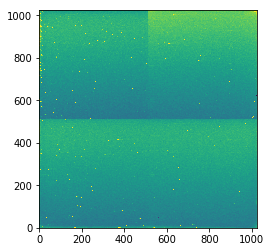

In [15]:
#MASTER_DARK

print("Creating and applying master darks and flats...\n")    

# create master dark matching science exposure times
med_dark = dark_combine(path_to_raw_sci, path_to_raw_darks, sci_exptime, imsize, objname) 

vmin, vmax = interval.get_limits(med_dark)
plt.imshow(med_dark, vmin=vmin, vmax=vmax, origin='lower')

In [16]:
# subtract off the median dark frame from each of the science frames
for ii in range (0, totalframes):
    sciarray[:,:,ii] -= med_dark


In [17]:
flatlist = glob.glob(path_to_raw_flats + '**/q*fits',recursive = True)
flatlist

['/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2160.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2161.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2162.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2163.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2164.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2166.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2167.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2168.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2169.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/

Found 55 total flats taken in Ks band filter.

Found 55 twilight flats with exposure times of 20.0. 

Creating new master dark for flats with 20.0s exposure. 

Found 5 darks with exposure times of 20.0. 



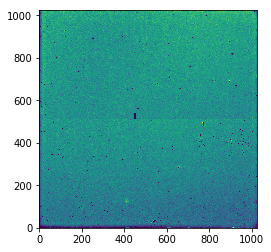

In [18]:
#MEDIAN_AND_MASTER_FLAT

# create the masterflat 
med_flat, master_flat, flatheader = process_flats(path_to_raw_sci, path_to_raw_flats, path_to_raw_darks, imsize, flattype, objname)

vmin, vmax = interval.get_limits(med_flat)
plt.imshow(med_flat, vmin=vmin, vmax=vmax, origin='lower')

In [19]:
# divide each science frame by the masterflat frame
for ii in range(0, totalframes):
    sciarray[:,:,ii] /= master_flat



Creating bad pixel map and correcting for bad pixels and cosmic rays. 
 This may take a moment... 



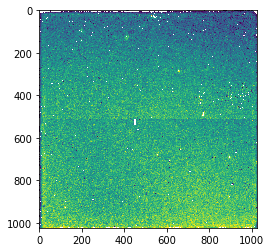

In [20]:
#BAD_PIXEL_MAP

print("Creating bad pixel map and correcting for bad pixels and cosmic rays. \n",
     "This may take a moment... \n") 

# create bad pixel map
badflat = badpixelmap(path_to_raw_sci, med_flat, objname, flatheader)  

vmin, vmax = interval.get_limits(badflat)
plt.imshow(badflat, vmin=vmin, vmax=vmax)

In [21]:
# correct the bad pixels and cosmic rays
reduced_sciarray = correct_bad_pixels(sciarray, badflat)


Correcting image #0
Correcting image #1
Correcting image #2
Correcting image #3
Correcting image #4
Correcting image #5
Correcting image #6
Correcting image #7
Correcting image #8
Correcting image #9
Correcting image #10
Correcting image #11
Correcting image #12
Correcting image #13
Correcting image #14
Correcting image #15
Correcting image #16
Correcting image #17
Correcting image #18
Correcting image #19
Correcting image #20
Correcting image #21
Correcting image #22
Correcting image #23
Correcting image #24
Correcting image #25
Correcting image #26
Correcting image #27
Correcting image #28
Correcting image #29
Correcting image #30
Correcting image #31
Correcting image #32
Correcting image #33
Correcting image #34
Correcting image #35
Correcting image #36


In [22]:
# write out a test reduced science image 
fits.writeto(path_to_raw_sci+'test_reduced_science.fits', reduced_sciarray[:,:,0], overwrite=True)

In [23]:
#MASTER_SKY
print("Creating master sky from science frames...\n") 

# create median sky from stack of science images
sky_output = create_sky_frames(path_to_raw_sci, reduced_sciarray, sciheader, objname, angle)



Creating master sky from science frames...



4.270112233641736


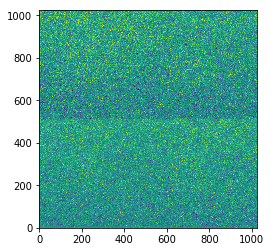

In [24]:
# get median and examine sky output:
print(np.median(sky_output[1]))
vmin, vmax = interval.get_limits(sky_output[1])
plt.imshow(sky_output[1], vmin=vmin, vmax=vmax, origin='lower')

In [25]:
# apply sky subtraction to each science image 
skysub_science_array, rot_flag = sky_subtract(reduced_sciarray, sky_output, angle)

In [26]:
#INDIVIDUAL_REDUCED_SCI_IMAGES
t0=time.time()

# initialize blank list to hold all of the reduced science image names
scinames_list = []


for ii in range(0, totalframes):
    print(f"Saving reduced frame #{ii}")
    sciname = 'reducedsci_00' + str(ii) + '.fits'
    if ii >= 10:
        sciname = 'reducedsci_0' + str(ii) + '.fits'
    if ii >= 100:
        sciname = 'reducedsci_' + str(ii) + '.fits'
    fits.writeto(path_to_raw_sci+sciname, skysub_science_array[:,:,ii], sciheader, overwrite = True, output_verify='silentfix')
    scinames_list.append(sciname)
    
t1=time.time()
print("Time taken: ", (t1-t0)/60.)

Saving reduced frame #0
Saving reduced frame #1
Saving reduced frame #2
Saving reduced frame #3
Saving reduced frame #4
Saving reduced frame #5
Saving reduced frame #6
Saving reduced frame #7
Saving reduced frame #8
Saving reduced frame #9
Saving reduced frame #10
Saving reduced frame #11
Saving reduced frame #12
Saving reduced frame #13
Saving reduced frame #14
Saving reduced frame #15
Saving reduced frame #16
Saving reduced frame #17
Saving reduced frame #18
Saving reduced frame #19
Saving reduced frame #20
Saving reduced frame #21
Saving reduced frame #22
Saving reduced frame #23
Saving reduced frame #24
Saving reduced frame #25
Saving reduced frame #26
Saving reduced frame #27
Saving reduced frame #28
Saving reduced frame #29
Saving reduced frame #30
Saving reduced frame #31
Saving reduced frame #32
Saving reduced frame #33
Saving reduced frame #34
Saving reduced frame #35
Saving reduced frame #36
Time taken:  0.05526606639226277


In [27]:
# get current directory where reduced frames are written
current_dir = path_to_raw_sci

# measure star positions in all of the images
xcen, ycen = measure_star_centers(path_to_raw_sci, skysub_science_array, scinames_list, sciheader, saturated, 0, current_dir, saveframes = True)


Moving IDL session to /Volumes/Passport4TB/MinMs_Data_Testing/HIP12097_MMT_20161012/0.8/
% Compiled module: MRDFITS.
% Compiled module: FXPOSIT.
% Compiled module: MRD_HREAD.
% Compiled module: FXPAR.
% Compiled module: GETTOK.
% Compiled module: VALID_NUM.
% Compiled module: MRD_SKIP.
% Compiled module: ARRAY_INDICES.
% Compiled module: GCNTRD.
Overwriting existing science frames with star position values: reducedsci_000.fits
Overwriting existing science frames with star position values: reducedsci_001.fits
Overwriting existing science frames with star position values: reducedsci_002.fits
Overwriting existing science frames with star position values: reducedsci_003.fits
Overwriting existing science frames with star position values: reducedsci_004.fits
Overwriting existing science frames with star position values: reducedsci_005.fits
Overwriting existing science frames with star position values: reducedsci_006.fits
Overwriting existing science frames with star position values: reduceds

In [28]:
print('xcen:', xcen, 'ycen:', ycen)

xcen: [217.68252563 316.64855957 277.30584717 229.46484375 175.04490662
 218.20860291 263.24066162 204.74188232 162.87765503 114.20948029
 343.59451294 303.46496582 257.34255981 203.76646423 246.29858398
 291.84628296 233.34268188 191.81407166 145.03059387 817.09484863
 779.27471924 739.45269775 678.13537598 719.62756348 761.12432861
 712.78735352 663.83837891 624.01623535 792.93310547 744.79046631
 703.63354492 647.92492676 691.18359375 739.13916016 688.48114014
 638.07281494 595.0557251 ] ycen: [303.05023193 291.8276062  339.51644897 401.22375488 359.22497559
 304.40158081 244.83293152 197.51580811 262.65789795 315.52157593
 777.93328857 835.73858643 890.60760498 859.55865479 800.34881592
 734.21087646 699.418396   755.73461914 806.28356934 755.63244629
 807.2869873  868.98602295 816.73236084 760.94189453 702.92224121
 660.91369629 722.55102539 769.58813477 262.75753784 323.17611694
 377.72583008 332.30221558 276.34133911 218.10955811 168.65716553
 227.56665039 284.19403076]


In [29]:
#SHIFTED_IMAGES
#STACKED
#FINAL
t0=time.time()
# final step (!) - shift and combine all of the images.
rotate_shift_align(path_to_raw_sci, xcen, ycen, angle, skysub_science_array, objname, sciheader, current_dir, imsize=1024)

t1 = time.time()
timetaken = (t1-t0)/60.
print(f"Completed reduction of {totalframes} images in {timetaken} minutes.")

2301 2292
Shifting image 0 of 37...
Shifting image 1 of 37...
Shifting image 2 of 37...
Shifting image 3 of 37...
Shifting image 4 of 37...
Shifting image 5 of 37...
Shifting image 6 of 37...
Shifting image 7 of 37...
Shifting image 8 of 37...
Shifting image 9 of 37...
Shifting image 10 of 37...
Shifting image 11 of 37...
Shifting image 12 of 37...
Shifting image 13 of 37...
Shifting image 14 of 37...
Shifting image 15 of 37...
Shifting image 16 of 37...
Shifting image 17 of 37...
Shifting image 18 of 37...
Shifting image 19 of 37...
Shifting image 20 of 37...
Shifting image 21 of 37...
Shifting image 22 of 37...
Shifting image 23 of 37...
Shifting image 24 of 37...
Shifting image 25 of 37...
Shifting image 26 of 37...
Shifting image 27 of 37...
Shifting image 28 of 37...
Shifting image 29 of 37...
Shifting image 30 of 37...
Shifting image 31 of 37...
Shifting image 32 of 37...
Shifting image 33 of 37...
Shifting image 34 of 37...
Shifting image 35 of 37...
Shifting image 36 of 37...
%








## Run all of the above reduction steps in one go:

In [6]:
#Running all the above reduction steps in one go
reduce_raw_sci(path_to_raw_sci, path_to_raw_darks, path_to_raw_flats, objname, flattype, saturated, alignflag, imsize = 1024)

Number of science frames found: 37 

Science frame exposure time: 0.8

Creating and applying master darks and flats...

Found 52 darks with exposure times of 0.8. 

Found 55 total flats taken in Ks band filter.

Found 55 twilight flats with exposure times of 20.0. 

Creating new master dark for flats with 20.0s exposure. 

Found 5 darks with exposure times of 20.0. 

Creating bad pixel map and correcting for bad pixels and cosmic rays. 
 This may take a moment... 

Correcting image #0
Correcting image #1
Correcting image #2
Correcting image #3
Correcting image #4
Correcting image #5
Correcting image #6
Correcting image #7
Correcting image #8
Correcting image #9
Correcting image #10
Correcting image #11
Correcting image #12
Correcting image #13
Correcting image #14
Correcting image #15
Correcting image #16
Correcting image #17
Correcting image #18
Correcting image #19
Correcting image #20
Correcting image #21
Correcting image #22
Correcting image #23
Correcting image #24
Correcting imag